In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In this post, I will demonstrate how you can use [emcee](https://emcee.readthedocs.io/en/latest/) to sample models defined using [PyMC3](https://docs.pymc.io/).
Thomas Wiecki [wrote about how to do this this with an earlier version of PyMC](http://twiecki.github.io/blog/2013/09/23/emcee-pymc/), but I needed an update since I wanted to do a comparison and PyMC's interface has changed a lot since he wrote his post.
This isn't necessarily something that you'll *want* to do, but I figured that I would post it here for posterity.

For simplicity, let's use the simulated data from my [previous blog post](/posts/pymc-tensorflow):

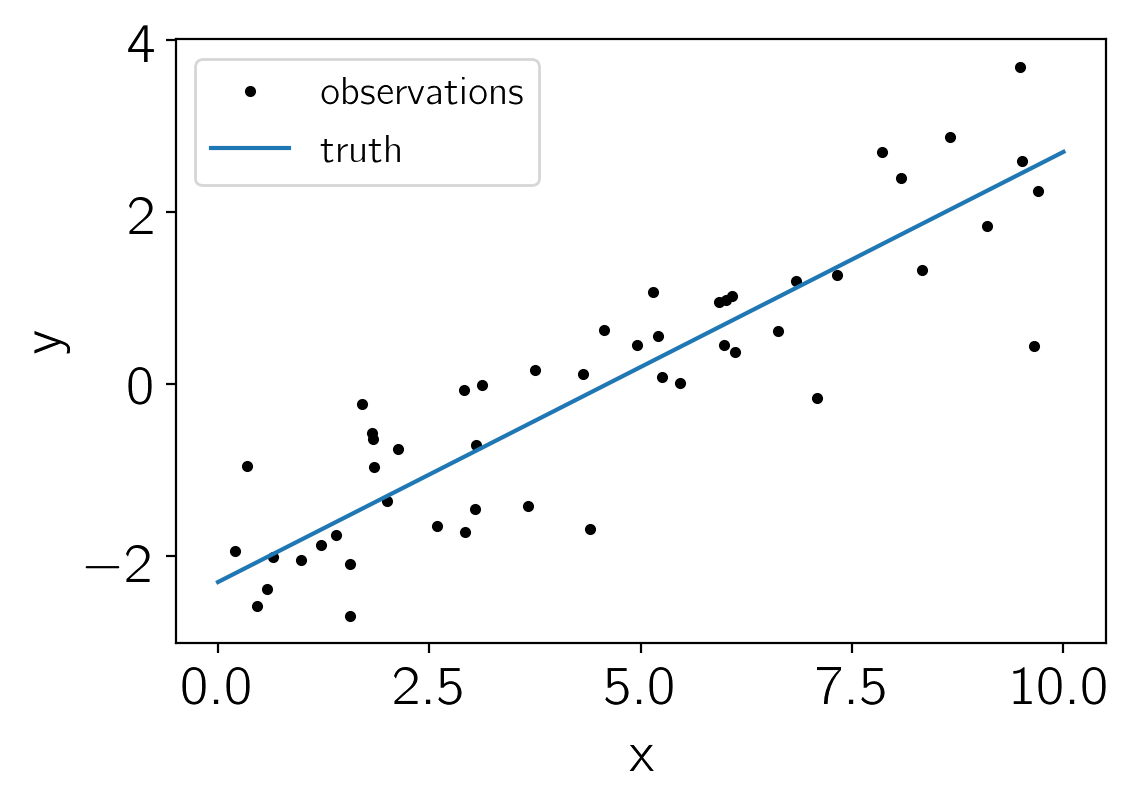

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

true_params = np.array([0.5, -2.3, -0.23])

N = 50
t = np.linspace(0, 10, 2)
x = np.random.uniform(0, 10, 50)
y = x * true_params[0] + true_params[1]
y_obs = y + np.exp(true_params[-1]) * np.random.randn(N)

plt.plot(x, y_obs, ".k", label="observations")
plt.plot(t, true_params[0]*t + true_params[1], label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=14);

Then, we can code up the model in PyMC3 following [Jake VanderPlas' notation](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/), and sample it using PyMC3's NUTS[sic] sampler:

In [3]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    logs = pm.Uniform("logs", lower=-10, upper=10)
    alphaperp = pm.Uniform("alphaperp", lower=-10, upper=10)
    theta = pm.Uniform("theta", -2*np.pi, 2*np.pi, testval=0.0)

    # alpha_perp = alpha * cos(theta)
    alpha = pm.Deterministic("alpha", alphaperp / tt.cos(theta))
    
    # beta = tan(theta)
    beta = pm.Deterministic("beta", tt.tan(theta))
    
    # The observation model
    mu = alpha * x + beta
    pm.Normal("obs", mu=mu, sd=tt.exp(logs), observed=y_obs)
    
    res = pm.find_MAP()
    trace = pm.sample(start=res, draws=2000, tune=2000)

logp = -63.46, ||grad|| = 386.74: 100%|██████████| 28/28 [00:00<00:00, 3719.41it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, alphaperp, logs]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1850.59draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


And we can take a look at the [corner plot](https://corner.readthedocs.io/en/latest/):

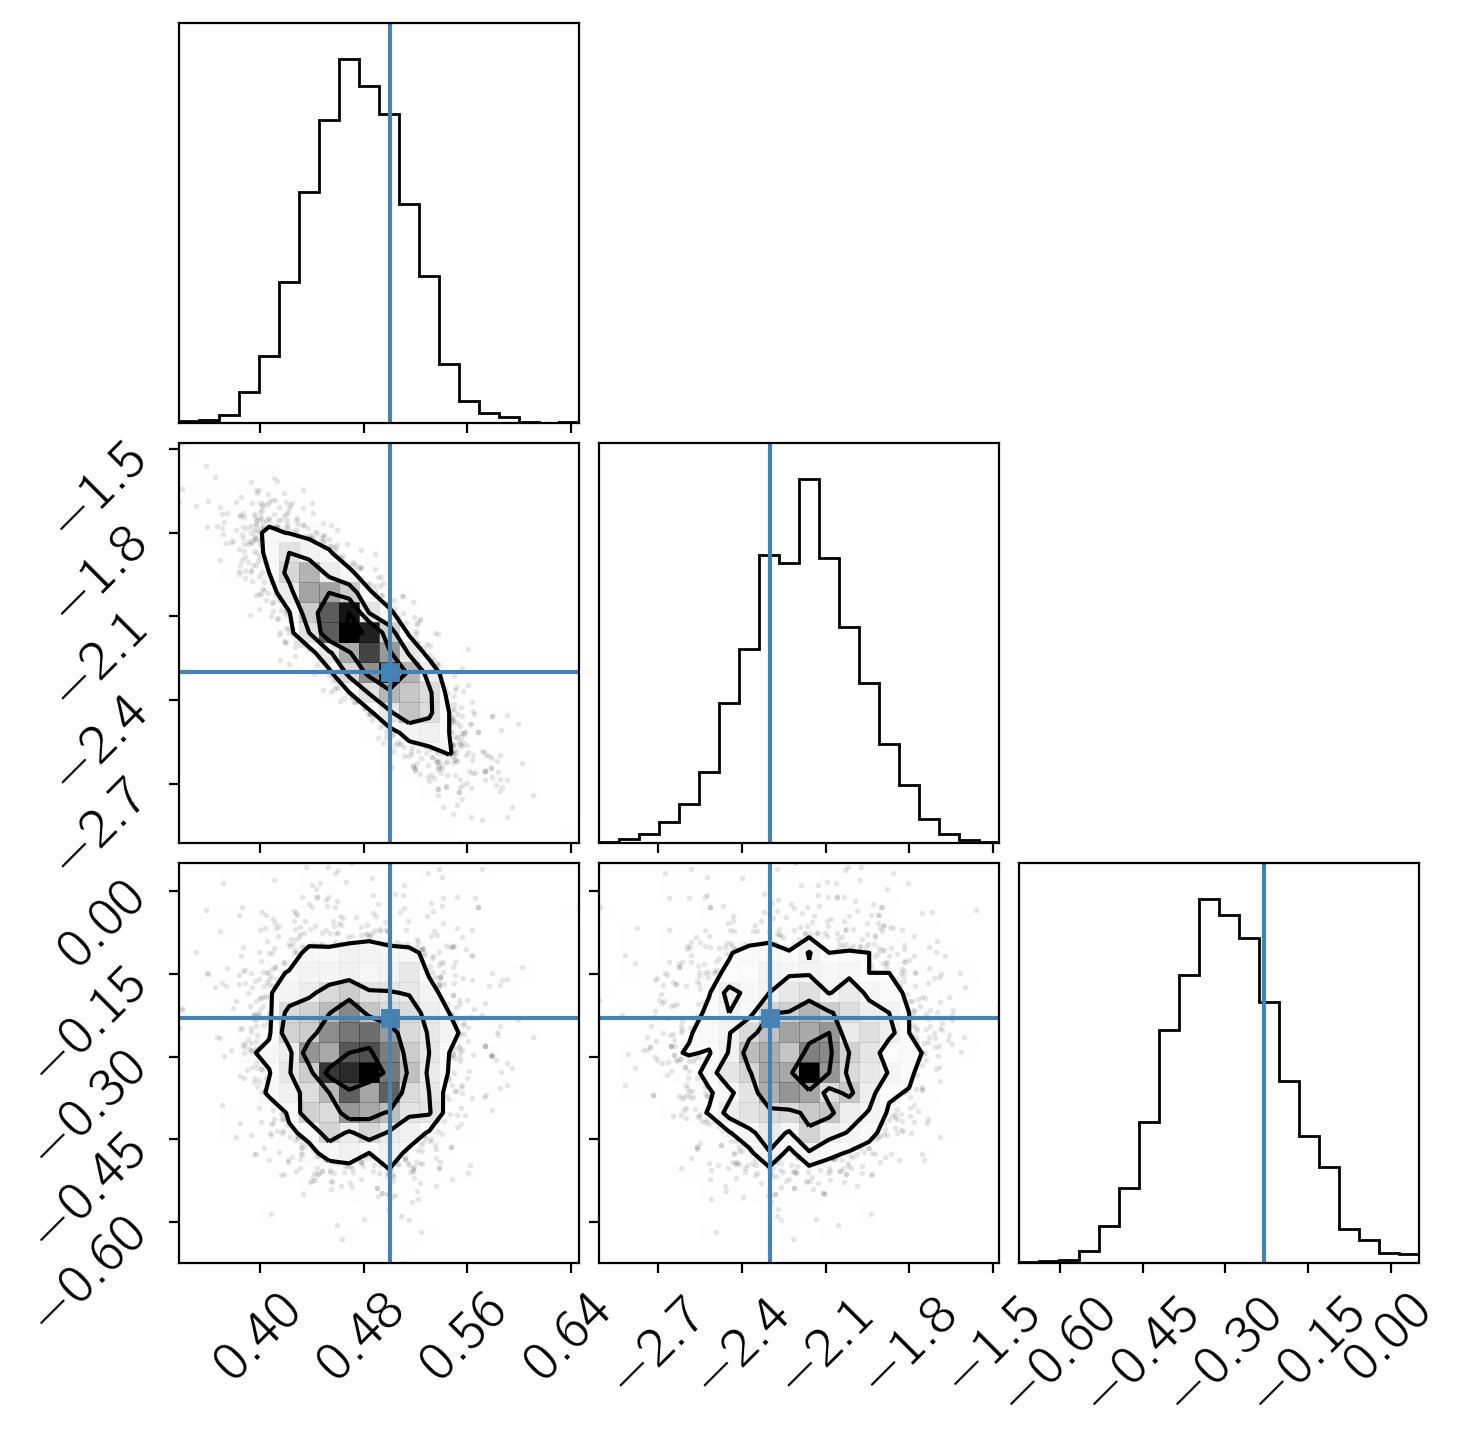

In [4]:
import corner
samples = np.vstack([trace[k] for k in ["alpha", "beta", "logs"]]).T
corner.corner(samples, truths=true_params);

## Sampling the PyMC3 model using emcee

To sample this using emcee, we'll need to do a little bit of bookkeeping.
I've coded this up using version 3 of emcee that is currently available as [the master branch on GitHub](https://github.com/dfm/emcee) or as [a pre-release on PyPI](https://pypi.org/project/emcee/3.0rc1/), so you'll need to install that version to run this.

First, we need to compute the shapes and sizes of all the variables (these are simple in this case because they are all scalars, but this code works for more complicated models as well):

In [5]:
with model:
    test_point = model.test_point
    vars = list(model.vars)
    names = [var.name for var in vars]
    values = [test_point[n] for n in names]
    shapes = [np.shape(v) for v in values]
    sizes = [np.size(v) for v in values]

Then we need a few functions to switch between PyMC3 variables and the arrays that emcee works with.
The first function converts a PyMC3 testpoint to a vector and the second takes that vector and converts it to a list of arrays in the same order as `model.vars`.

In [6]:
def dict_to_vector(dct):
    vector = np.empty(np.sum(sizes))
    i = 0
    for name, size in zip(names, sizes):
        vector[i:i+size] = dct[name].flatten()
        i += size
    return vector

def vector_to_values(vector):
    values = []
    i = 0
    for shape, size in zip(shapes, sizes):
        values.append(np.reshape(vector[i:i+size], shape))
        i += size
    return values

with model:
    print("Test point vector: {0}".format(dict_to_vector(model.test_point)))

Test point vector: [0. 0. 0.]


And then, finally, we can define the log probability function that emcee needs.
The only interesting here is that we also return the values of all the deterministic variables using the ["blobs" feature in emcee](https://emcee.readthedocs.io/en/latest/user/blobs/).

In [7]:
import theano

with model:
    f = theano.function(model.vars, [model.logpt] + model.deterministics)
    
    def log_prob_func(params):
        values = vector_to_values(params)
        results = f(*values)
        return tuple(results)

And now we can run the sampler:

In [8]:
import emcee

with model:
    # First we work out the shapes of all of the deterministic variables
    vec = dict_to_vector(res)
    initial_blobs = log_prob_func(vec)[1:]
    dtype = [(var.name, float, np.shape(b)) for var, b in zip(model.deterministics, initial_blobs)]
    
    # Then sample as usual
    coords = vec + 1e-5 * np.random.randn(25, len(vec))
    nwalkers, ndim = coords.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_func, blobs_dtype=dtype)
    sampler.run_mcmc(coords, 5000, progress=True)

100%|██████████| 5000/5000 [00:06<00:00, 737.50it/s]


And we can use this to make the same corner plot as above:

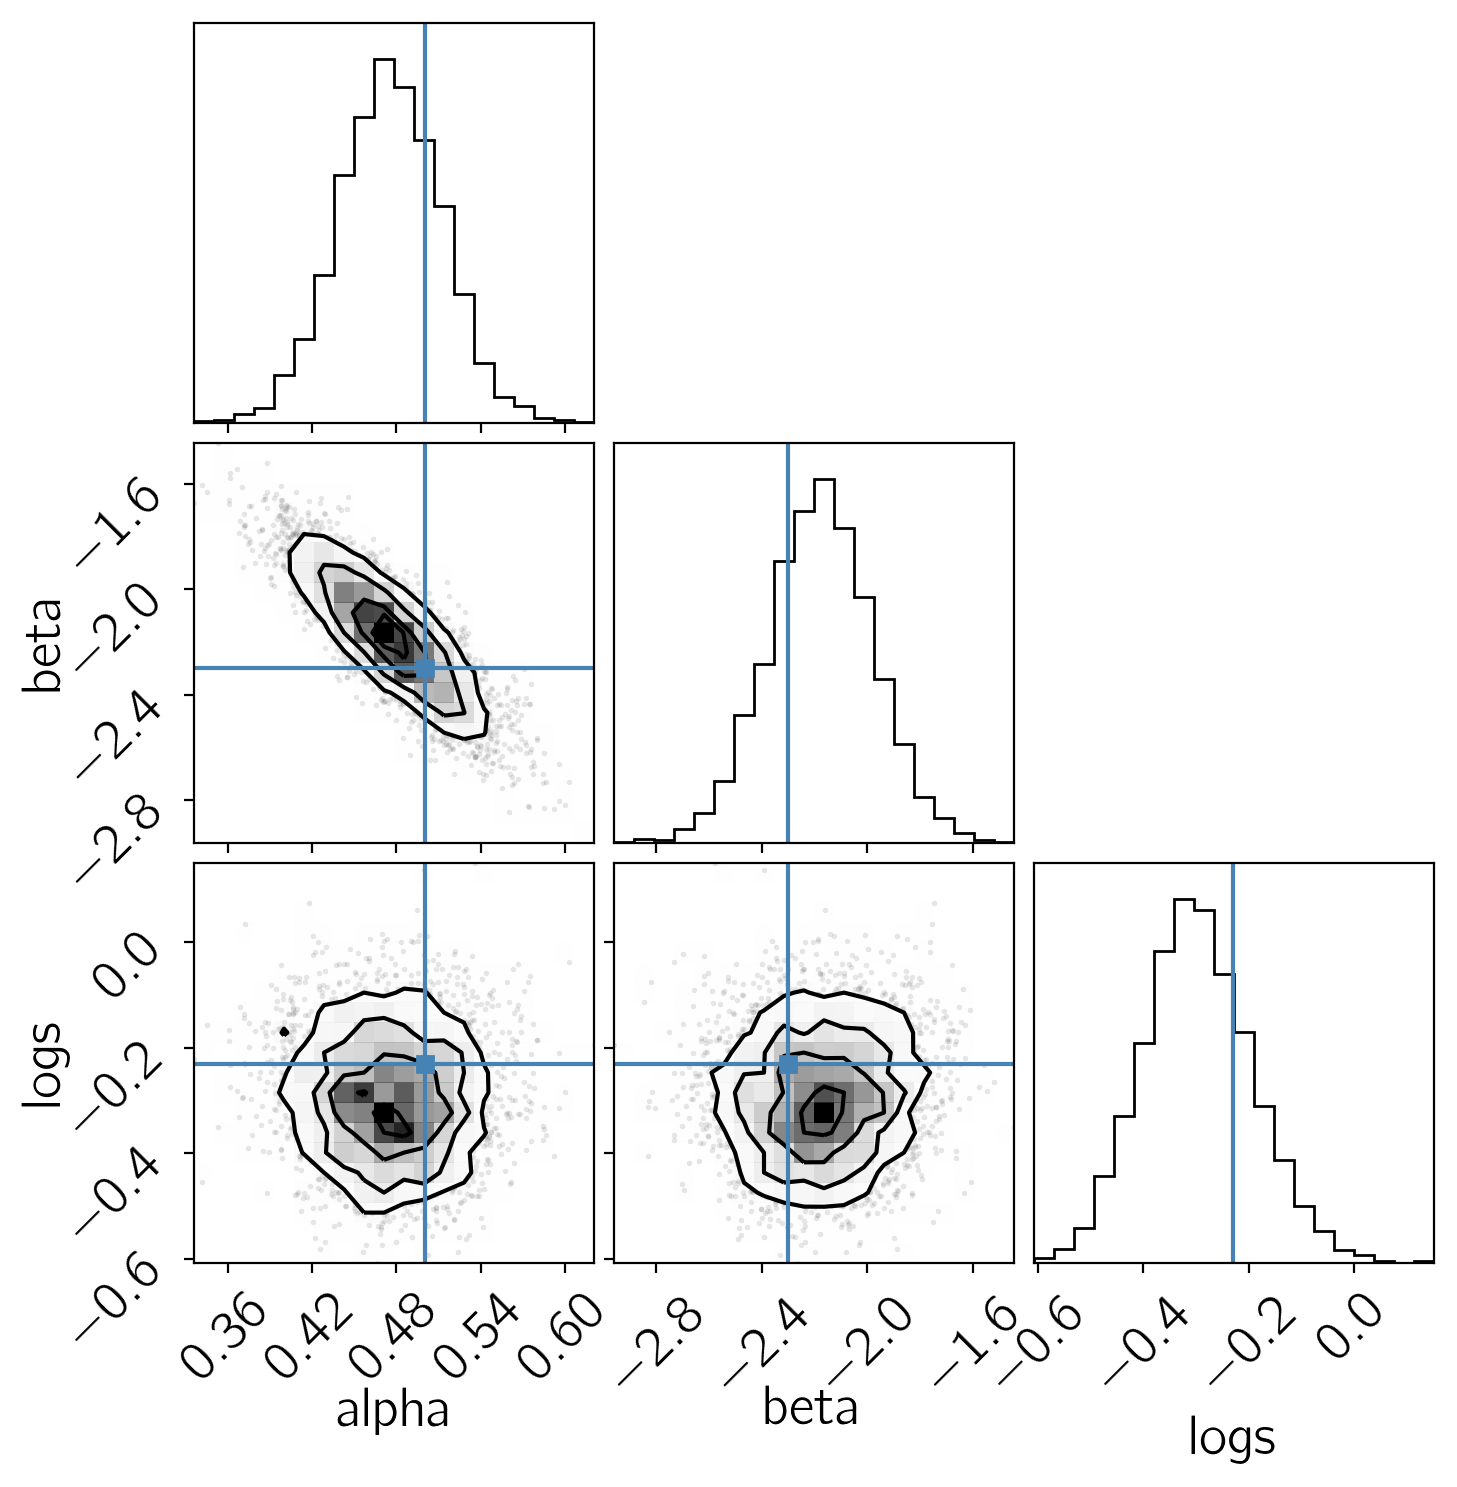

In [9]:
import pandas as pd
df = pd.DataFrame.from_records(sampler.get_blobs(flat=True, discard=100, thin=30))
corner.corner(df[["alpha", "beta", "logs"]], truths=true_params);

The last thing that we might want to look at is [the integrated autocorrelation time](/posts/autocorr/) for each method.
First, as expected, the autocorrelation for PyMC3 is very short (about 1 step):

In [10]:
[float(emcee.autocorr.integrated_time(np.array(trace.get_values(var.name, combine=False)).T)) for var in model.free_RVs]

[1.0695261055492038, 0.9414537023055778, 0.9243302234550985]

And, the autocorrelation for emcee is about 30 steps:

In [11]:
sampler.get_autocorr_time(discard=100)

array([39.64694934, 32.94941486, 34.56135236])

If you want to compare these results in detail, you'll want to make sure that you take into account the fact that each step of NUTS is significantly more expensive than one step with emcee, but that's way beyond the scope of this post...